## Importando librerias

In [66]:
import torch
import pytorch_lightning as pl
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset, Subset
from collections import OrderedDict
import numpy as np
from torchvision.datasets import ImageFolder
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random

## Configuracion de Variables

In [67]:
# Coloca aquí la ruta a tu modelo .pth (el checkpoint de Lightning)
PATH_MODELO_SSL = "/lustre/proyectos/p032/models/multi_pretext_model2.ckpt"
MODEL_PATH = "models/221025MG_backbone.ssl.pth"

# Apunta al directorio raíz del dataset renombrado
DATASET = '/lustre/home/jreyes/MEDA_Challenge/compartido/datasets/daudon_dataset'
PATH_DATASET = "/lustre/home/jreyes/MEDA_Challenge/compartido/datasets/daudon_dataset/test"

# Define el número de clases de tu dataset
NUM_CLASES = 6

# Parámetros para el modelo y entrenamiento
LEARNING_RATE = 0.3e-4
JIGSAW_N = 4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define las proporciones del split del dataset
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 1.0 - TRAIN_RATIO - VAL_RATIO 

# Para Hacer Few Shot Learning
K_SHOTS = 5  

epochs_per_k = {
    1: 400,   
    5: 300,   
    10: 250, 
    20: 200,  
    50: 150    
}

EPOCHS_DE_PRUEBA = epochs_per_k[K_SHOTS]

batch_sizes = {
    1: 64,     
    5: 128,    
    10: 256,   
    20: 512,  
    50: 1024   
}
BATCH_SIZE = batch_sizes[K_SHOTS]



# --------------------------------------------------------
# 1. FIJAR SEMILLA ALEATORIA
# --------------------------------------------------------
SEED = 46  # Puedes cambiarlo a cualquier número
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # si usas GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Importación del Modelo SSL

In [68]:
class MultiPretextSSL_Lightning(pl.LightningModule):
    def __init__(self, backbone, learning_rate=1e-4):
        super().__init__()
        self.save_hyperparameters('learning_rate')
        self.backbone = backbone
        self.lr = learning_rate

        num_features = 512  # salida de ResNet18

        # Decoders de pretext (se mantienen aunque no los uses aquí)
        decoder_layers_28x28 = [
            nn.ConvTranspose2d(num_features, 256, 4, 1, 0),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 3, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Sigmoid()
        ]
        self.color_head = nn.Sequential(*decoder_layers_28x28)
        self.patch_head = nn.Sequential(*decoder_layers_28x28)

        # dentro de __init__ de MultiPretextSSL_Lightning
        self.n_patches = JIGSAW_N * JIGSAW_N  # e.g. 4*4 = 16
        self.jigsaw_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Linear(512, self.n_patches)   # <-- CORRECCIÓN: salida = n_patches (16)
)

    def forward(self, x, task="color"):
        feats = self.backbone(x)
        if task == "color":
            return self.color_head(feats)
        elif task == "patch":
            return self.patch_head(feats)
        elif task == "jigsaw":
            return self.jigsaw_head(feats)

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.lr)

# --- Carga del backbone SSL ---
resnet = models.resnet18(weights=None)
backbone_structure = nn.Sequential(*list(resnet.children())[:-1])  # sin FC

class MoCoLightning(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.encoder_q = nn.Sequential(backbone)

encoder_wrapper = MoCoLightning(backbone=backbone_structure)
state_dict = torch.load(MODEL_PATH, map_location=DEVICE)
encoder_wrapper.encoder_q[0].load_state_dict(state_dict)

ssl_backbone = encoder_wrapper.encoder_q[0].to(DEVICE)
print("✅ Backbone SSL cargado correctamente en GPU.")

# --- Cargar checkpoint Lightning (opcional si tienes otro entrenamiento) ---
model_ssl = MultiPretextSSL_Lightning.load_from_checkpoint(PATH_MODELO_SSL, backbone=ssl_backbone)
print("✅ Modelo SSL reconstruido con éxito.")

# Congelar backbone completo (el fine-tuning se maneja en LinearProbingModel)
for param in model_ssl.backbone.parameters():
    param.requires_grad = False

in_features = 512

✅ Backbone SSL cargado correctamente en GPU.
✅ Modelo SSL reconstruido con éxito.


## Creacion de Dataset

In [69]:
data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomApply([
        transforms.ColorJitter(0.2, 0.2, 0.2, 0.1)
    ], p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

try:
    full_dataset = ImageFolder(PATH_DATASET, transform=data_transform)
    print(f"Dataset completo cargado desde: {PATH_DATASET}")
    print(f"Total de imágenes encontradas: {len(full_dataset)}")
    print(f"Clases (carpetas) encontradas: {full_dataset.classes}")
    
    if len(full_dataset.classes) != NUM_CLASES:
        print(f"¡Advertencia! Se esperaban {NUM_CLASES} clases pero se encontraron {len(full_dataset.classes)} carpetas.")
        NUM_CLASES = len(full_dataset.classes)
        print(f"NUM_CLASES actualizado a {NUM_CLASES}")

except FileNotFoundError:
    print(f"Error: No se encontró el directorio {PATH_DATASET}")
    print("Asegúrate de que 'PATH_DATASET' apunte al directorio que contiene las carpetas de tus clases.")
    raise

targets = full_dataset.targets
indices = list(range(len(targets)))

train_indices, val_test_indices, train_targets, val_test_targets = train_test_split(
    indices,
    targets,
    train_size=TRAIN_RATIO,
    stratify=targets, 
    random_state=SEED
)

test_split_ratio = TEST_RATIO / (VAL_RATIO + TEST_RATIO) 

val_indices, test_indices = train_test_split(
    val_test_indices,
    test_size=test_split_ratio,
    stratify=val_test_targets, 
    random_state=SEED
)

print(f"Dividiendo dataset (estratificado): {len(train_indices)} (Train), {len(val_indices)} (Val), {len(test_indices)} (Test)")

# Creando Datasets usando torch.utils.data.Subset
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)
test_dataset = Subset(full_dataset, test_indices)

# Cargando los datasets
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"DataLoaders creados. Tamaño train: {len(train_dataset)}, val: {len(val_dataset)}")

Dataset completo cargado desde: /lustre/home/jreyes/MEDA_Challenge/compartido/datasets/daudon_dataset/test
Total de imágenes encontradas: 2400
Clases (carpetas) encontradas: ['MIX-Subtype_IVa', 'MIX-Subtype_IVa2', 'MIX-Subtype_IVc', 'MIX-Subtype_IVd', 'MIX-Subtype_Ia', 'MIX-Subtype_Va']
Dividiendo dataset (estratificado): 1920 (Train), 240 (Val), 240 (Test)
DataLoaders creados. Tamaño train: 1920, val: 240


/lustre/proyectos/p032/env/lib64/python3.9/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Creando el dataset para FSL

In [70]:

print(f"Creando un Support Set de {K_SHOTS}-shot a partir de los {len(train_indices)} datos de entrenamiento...")


train_targets_np = np.array(train_targets)
train_indices_np = np.array(train_indices) # Índices que apuntan a full_dataset

classes = np.unique(train_targets_np)
n_classes = len(classes)

# 3. Recolectar los índices originales (de full_dataset) para nuestro support set
support_indices = []
for c in classes:
    # 4. Encontrar los índices (dentro de train_indices_np) que pertenecen a la clase 'c'
    class_mask = (train_targets_np == c)
    
    # 5. Obtener los índices *originales* (de full_dataset) para esa clase
    all_indices_for_class_in_train = train_indices_np[class_mask]
    
    # 6. Seleccionar K_SHOTS al azar
    if len(all_indices_for_class_in_train) < K_SHOTS:
        print(f"¡Advertencia! Clase {c} solo tiene {len(all_indices_for_class_in_train)} muestras en el set de entto. Usando todas.")
        k_shot_indices = all_indices_for_class_in_train
    else:
        # Selecciona K índices al azar (sin reemplazo) de este grupo
        k_shot_indices = np.random.choice(all_indices_for_class_in_train, K_SHOTS, replace=False)
        
    support_indices.extend(k_shot_indices)

print(f"Total de muestras en el Support Set: {len(support_indices)} ({n_classes} clases * {K_SHOTS} shots)")

# 7. Crear el nuevo Dataset y DataLoader "Few-Shot"
#    OJO: Se crea a partir de `full_dataset` usando los índices que seleccionamos
few_shot_dataset = Subset(full_dataset, support_indices)

# 8. ¡Este es el DataLoader que usarás en tu bucle de entrenamiento!
few_shot_train_loader = DataLoader(
    few_shot_dataset,
    batch_size=BATCH_SIZE, # Puedes usar el mismo BATCH_SIZE o uno más pequeño
    shuffle=True,          # ¡Importante barajar tu pequeño set!
    num_workers=2
)

print(f"DataLoader Few-Shot ('few_shot_train_loader') creado con {len(few_shot_dataset)} imágenes.")
print("--------------------------------------------------------")

Creando un Support Set de 5-shot a partir de los 1920 datos de entrenamiento...
Total de muestras en el Support Set: 30 (6 clases * 5 shots)
DataLoader Few-Shot ('few_shot_train_loader') creado con 30 imágenes.
--------------------------------------------------------


## Creando Cabezal de Clasificación

In [71]:
class LinearProbingModel(nn.Module):
    def __init__(self, backbone, num_classes, fine_tune_last_block=True):
        super().__init__()
        self.backbone = backbone

        # Fine-tune suave (último bloque)
        for name, param in self.backbone.named_parameters():
            if fine_tune_last_block and ("layer4" in name or "bn1" in name):
                param.requires_grad = True
            else:
                param.requires_grad = False

        # Cabeza MLP ligera pero estable (mejor que lineal pura)
        self.linear_head = nn.Sequential(
            nn.Linear(512, 256),
            nn.LayerNorm(256),   # más estable que BatchNorm para mini-batchs pequeños
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        feats = self.backbone(x)
        feats = feats.view(feats.size(0), -1)
        out = self.linear_head(feats)
        return out


# === Configuración del modelo ===
model = LinearProbingModel(backbone=model_ssl.backbone, num_classes=NUM_CLASES).to(DEVICE)


criterion = nn.CrossEntropyLoss()

# Optimizador más flexible (AdamW con decay y warmup-like behavior)
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()), 
    lr=3e-4, weight_decay=1e-4
)

# Programador de tasa de aprendizaje tipo cosine annealing
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)


## Entrenamiento de Cabezal y haciendo Few Shot Learning

In [72]:
import copy

print("Iniciando entrenamiento de la cabeza lineal (Few Shot learning)...")

best_val_acc = 0.0
best_weights = None
patience = 30           # Paciencia para early stopping
wait = 0
min_delta = 1e-4        # Mínima mejora para resetear patience

for epoch in range(EPOCHS_DE_PRUEBA):
    model.train()
    running_loss = 0.0

    # ---- Train ----
    for inputs, labels in few_shot_train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(few_shot_train_loader.dataset)

    # ---- Validación ----
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss /= len(val_loader.dataset)
    val_acc = 100 * correct / total

    print(f"Epoch {epoch+1}/{EPOCHS_DE_PRUEBA} - "
          f"Train Loss: {epoch_loss:.4f} - "
          f"Val Loss: {val_loss:.4f} - "
          f"Val Acc: {val_acc:.2f}%")

    # ---- Early stopping y guardado del mejor checkpoint ----
    if val_acc > best_val_acc + min_delta:
        best_val_acc = val_acc
        best_weights = copy.deepcopy(model.state_dict())
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print(f"⏹ Early stopping activado en epoch {epoch+1}")
            break

print("Entrenamiento de la cabeza finalizado.")

# ---- Cargar el mejor checkpoint ----
if best_weights is not None:
    model.load_state_dict(best_weights)
    print(f"✅ Mejor modelo cargado con Val Acc: {best_val_acc:.2f}%")

# --- 6. EVALUAR EL RENDIMIENTO ---
print("Evaluando en el set de testeo (división estratificada)...")

model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

accuracy = 100 * (all_preds == all_labels).sum() / len(all_labels)
print("\n========================================================")
print(f"🎉 ¡Prueba de Evaluación Lineal (Linear Probing) completa! 🎉")
print(f"    Accuracy en el set de testeo: {accuracy:.2f} %")
print("========================================================")
   

Iniciando entrenamiento de la cabeza lineal (Few Shot learning)...
Epoch 1/300 - Train Loss: 1.9254 - Val Loss: 1.8821 - Val Acc: 15.83%
Epoch 2/300 - Train Loss: 1.7477 - Val Loss: 1.8645 - Val Acc: 13.75%
Epoch 3/300 - Train Loss: 1.7010 - Val Loss: 1.8505 - Val Acc: 12.92%
Epoch 4/300 - Train Loss: 1.6481 - Val Loss: 1.8545 - Val Acc: 12.92%
Epoch 5/300 - Train Loss: 1.6116 - Val Loss: 1.8405 - Val Acc: 17.92%
Epoch 6/300 - Train Loss: 1.5870 - Val Loss: 1.8481 - Val Acc: 19.17%
Epoch 7/300 - Train Loss: 1.5839 - Val Loss: 1.8397 - Val Acc: 22.08%
Epoch 8/300 - Train Loss: 1.5304 - Val Loss: 1.8113 - Val Acc: 26.25%
Epoch 9/300 - Train Loss: 1.5168 - Val Loss: 1.7735 - Val Acc: 27.08%
Epoch 10/300 - Train Loss: 1.4182 - Val Loss: 1.7696 - Val Acc: 29.58%
Epoch 11/300 - Train Loss: 1.3807 - Val Loss: 1.7077 - Val Acc: 27.08%
Epoch 12/300 - Train Loss: 1.2832 - Val Loss: 1.6975 - Val Acc: 35.00%
Epoch 13/300 - Train Loss: 1.2805 - Val Loss: 1.6435 - Val Acc: 36.67%
Epoch 14/300 - Trai

## Matriz de Clasificacion


Generando matriz de confusión para las clases: ['MIX-Subtype_IVa', 'MIX-Subtype_IVa2', 'MIX-Subtype_IVc', 'MIX-Subtype_IVd', 'MIX-Subtype_Ia', 'MIX-Subtype_Va']


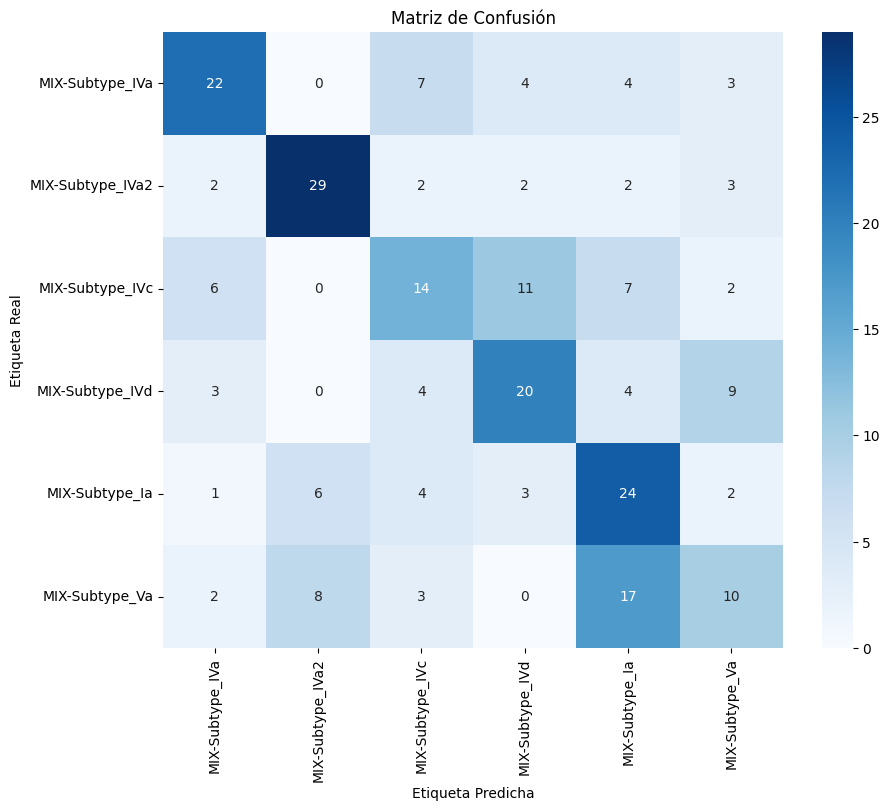

In [73]:

class_names = full_dataset.classes
print(f"\nGenerando matriz de confusión para las clases: {class_names}")

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusión')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.show()

## Resnet 18


In [74]:
print("\n" + "="*50)
print(" 🚀 INICIANDO EXPERIMENTO 1: ResNet-18 🚀")
print("="*50)

# 1. Cargar modelo ResNet-18 pre-entrenado
model_18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# 2. Congelar todas las capas del backbone
for param in model_18.parameters():
    param.requires_grad = False

# 3. Reemplazar la cabeza (capa 'fc')
in_features_18 = model_18.fc.in_features
model_18.fc = nn.Linear(in_features_18, NUM_CLASES)

# 4. Mover modelo al DEVICE
model_18 = model_18.to(DEVICE)

# 5. Crear optimizador (SOLO para los parámetros de la nueva cabeza)
optimizer_18 = optim.Adam(filter(lambda p: p.requires_grad, model_18.parameters()), lr=LEARNING_RATE)

# --- Early stopping variables ---
best_val_acc = 0.0
best_weights = None
patience = 10
wait = 0
min_delta = 1e-4

# --- Bucle de Entrenamiento ---
print("Iniciando entrenamiento de la cabeza lineal (Few Shot / ResNet-18)...")

for epoch in range(EPOCHS_DE_PRUEBA):
    model_18.train()
    running_loss = 0.0
    
    # ---- Train ----
    for inputs, labels in few_shot_train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer_18.zero_grad()
        outputs = model_18(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_18.step()
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(few_shot_train_loader.dataset)

    # ---- Validación ----
    model_18.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model_18(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss /= len(val_loader.dataset)
    val_acc = 100 * correct / total

    print(f"Epoch {epoch+1}/{EPOCHS_DE_PRUEBA} - "
          f"Train Loss: {epoch_loss:.4f} - "
          f"Val Loss: {val_loss:.4f} - "
          f"Val Acc: {val_acc:.2f}%")

    # ---- Early stopping y guardado del mejor checkpoint ----
    if val_acc > best_val_acc + min_delta:
        best_val_acc = val_acc
        best_weights = copy.deepcopy(model_18.state_dict())
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print(f"⏹ Early stopping activado en epoch {epoch+1}")
            break

print("Entrenamiento de la cabeza (ResNet-18) finalizado.")

# ---- Cargar el mejor checkpoint ----
if best_weights is not None:
    model_18.load_state_dict(best_weights)
    print(f"✅ Mejor modelo cargado con Val Acc: {best_val_acc:.2f}%")

# --- Evaluación (ResNet-18) ---
print("Evaluando ResNet-18 en el set de testeo...")
model_18.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model_18(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

accuracy_18 = 100 * (all_preds == all_labels).sum() / len(all_labels)
print("\n========================================================")
print(f"🎉 ¡Prueba de ResNet-18 completa! 🎉")
print(f"    Accuracy en el set de testeo: {accuracy_18:.2f} %")
print("========================================================")



 🚀 INICIANDO EXPERIMENTO 1: ResNet-18 🚀
Iniciando entrenamiento de la cabeza lineal (Few Shot / ResNet-18)...


/lustre/proyectos/p032/env/lib64/python3.9/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/300 - Train Loss: 1.9653 - Val Loss: 2.0056 - Val Acc: 15.00%
Epoch 2/300 - Train Loss: 1.8458 - Val Loss: 1.9754 - Val Acc: 14.17%
Epoch 3/300 - Train Loss: 1.8629 - Val Loss: 1.9783 - Val Acc: 12.92%
Epoch 4/300 - Train Loss: 1.9685 - Val Loss: 1.9796 - Val Acc: 13.33%
Epoch 5/300 - Train Loss: 1.9283 - Val Loss: 1.9644 - Val Acc: 13.75%
Epoch 6/300 - Train Loss: 1.8469 - Val Loss: 1.9615 - Val Acc: 13.33%
Epoch 7/300 - Train Loss: 1.9418 - Val Loss: 1.9770 - Val Acc: 12.08%
Epoch 8/300 - Train Loss: 1.9644 - Val Loss: 1.9271 - Val Acc: 14.58%
Epoch 9/300 - Train Loss: 1.9993 - Val Loss: 1.9610 - Val Acc: 12.08%
Epoch 10/300 - Train Loss: 1.8650 - Val Loss: 1.9509 - Val Acc: 15.42%
Epoch 11/300 - Train Loss: 1.9265 - Val Loss: 1.9348 - Val Acc: 12.50%
Epoch 12/300 - Train Loss: 1.9159 - Val Loss: 1.9445 - Val Acc: 14.17%
Epoch 13/300 - Train Loss: 1.9105 - Val Loss: 1.9204 - Val Acc: 18.75%
Epoch 14/300 - Train Loss: 1.9180 - Val Loss: 1.9397 - Val Acc: 17.92%
Epoch 15/300 - 

## Resnet 50

In [75]:
print("\n" + "="*50)
print(" 🚀 INICIANDO EXPERIMENTO 2: ResNet-50 🚀")
print("="*50)

# 1. Cargar modelo ResNet-50 pre-entrenado
model_50 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# 2. Congelar todas las capas del backbone
for param in model_50.parameters():
    param.requires_grad = False

# 3. Reemplazar la cabeza (capa 'fc')
in_features_50 = model_50.fc.in_features
model_50.fc = nn.Linear(in_features_50, NUM_CLASES)

# 4. Mover modelo al DEVICE
model_50 = model_50.to(DEVICE)

# 5. Crear optimizador (SOLO para los parámetros de la nueva cabeza)
optimizer_50 = optim.Adam(filter(lambda p: p.requires_grad, model_50.parameters()), lr=LEARNING_RATE)

# --- Early stopping variables ---
best_val_acc = 0.0
best_weights = None
patience = 10
wait = 0
min_delta = 1e-4

# --- Bucle de Entrenamiento ---
print("Iniciando entrenamiento de la cabeza lineal (Few Shot / ResNet-50)...")

for epoch in range(EPOCHS_DE_PRUEBA):
    model_50.train()
    running_loss = 0.0
    
    # ---- Train ----
    for inputs, labels in few_shot_train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer_50.zero_grad()
        outputs = model_50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_50.step()
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(few_shot_train_loader.dataset)

    # ---- Validación ----
    model_50.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model_50(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss /= len(val_loader.dataset)
    val_acc = 100 * correct / total

    print(f"Epoch {epoch+1}/{EPOCHS_DE_PRUEBA} - "
          f"Train Loss: {epoch_loss:.4f} - "
          f"Val Loss: {val_loss:.4f} - "
          f"Val Acc: {val_acc:.2f}%")

    # ---- Early stopping y guardado del mejor checkpoint ----
    if val_acc > best_val_acc + min_delta:
        best_val_acc = val_acc
        best_weights = copy.deepcopy(model_50.state_dict())
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print(f"⏹ Early stopping activado en epoch {epoch+1}")
            break

print("Entrenamiento de la cabeza (ResNet-50) finalizado.")

# ---- Cargar el mejor checkpoint ----
if best_weights is not None:
    model_50.load_state_dict(best_weights)
    print(f"✅ Mejor modelo cargado con Val Acc: {best_val_acc:.2f}%")

# --- Evaluación (ResNet-50) ---
print("Evaluando ResNet-50 en el set de testeo...")
model_50.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model_50(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

accuracy_50 = 100 * (all_preds == all_labels).sum() / len(all_labels)
print("\n========================================================")
print(f"🎉 ¡Prueba de ResNet-50 completa! 🎉")
print(f"    Accuracy en el set de testeo: {accuracy_50:.2f} %")
print("========================================================")



 🚀 INICIANDO EXPERIMENTO 2: ResNet-50 🚀
Iniciando entrenamiento de la cabeza lineal (Few Shot / ResNet-50)...
Epoch 1/300 - Train Loss: 1.7829 - Val Loss: 1.8058 - Val Acc: 10.42%
Epoch 2/300 - Train Loss: 1.7600 - Val Loss: 1.7979 - Val Acc: 14.17%
Epoch 3/300 - Train Loss: 1.7796 - Val Loss: 1.7894 - Val Acc: 16.67%
Epoch 4/300 - Train Loss: 1.7492 - Val Loss: 1.7878 - Val Acc: 17.50%
Epoch 5/300 - Train Loss: 1.7945 - Val Loss: 1.7895 - Val Acc: 20.00%
Epoch 6/300 - Train Loss: 1.7456 - Val Loss: 1.7954 - Val Acc: 17.50%
Epoch 7/300 - Train Loss: 1.7500 - Val Loss: 1.7883 - Val Acc: 21.25%
Epoch 8/300 - Train Loss: 1.7321 - Val Loss: 1.7892 - Val Acc: 21.25%
Epoch 9/300 - Train Loss: 1.7519 - Val Loss: 1.7909 - Val Acc: 16.25%
Epoch 10/300 - Train Loss: 1.7451 - Val Loss: 1.7931 - Val Acc: 15.00%
Epoch 11/300 - Train Loss: 1.7732 - Val Loss: 1.7971 - Val Acc: 14.58%
Epoch 12/300 - Train Loss: 1.7342 - Val Loss: 1.7813 - Val Acc: 19.17%
Epoch 13/300 - Train Loss: 1.7656 - Val Loss: 

In [76]:
print(f"K={K_SHOTS}, Semilla={SEED}, BatchSize={BATCH_SIZE}")
print("SSL: ", accuracy)
print("Resnet18: ", accuracy_18)
print("Resnet50: ", accuracy_50)

K=5, Semilla=46, BatchSize=128
SSL:  49.583333333333336
Resnet18:  18.75
Resnet50:  30.833333333333332
